In [1]:
# The pip install can take a minute
#%pip install -q urllib3<2.0 datascience ipywidgets
#import pyodide_http
#pyodide_http.patch_all()

import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')

In [2]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about.


def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='#1e90ff'):
    y = x*slope + intercept
    plots.plot(x, y, color=color, lw=3)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color, lw=3)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_scatter(r):
    """Generate a scatter plot with a correlation approximately r"""
    plots.figure(figsize=(5,5))
    x, y = make_correlated_data(r)
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

# Lecture 30

In [3]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x)

In [4]:
def correlation(t, x, y):
    """t is a table; x and y are column labels"""
    x_in_standard_units = standard_units(t.column(x))
    y_in_standard_units = standard_units(t.column(y))
    return np.average(x_in_standard_units * y_in_standard_units)

In [5]:
hybrid = Table.read_table('hybrid.csv')
hybrid.show(3)

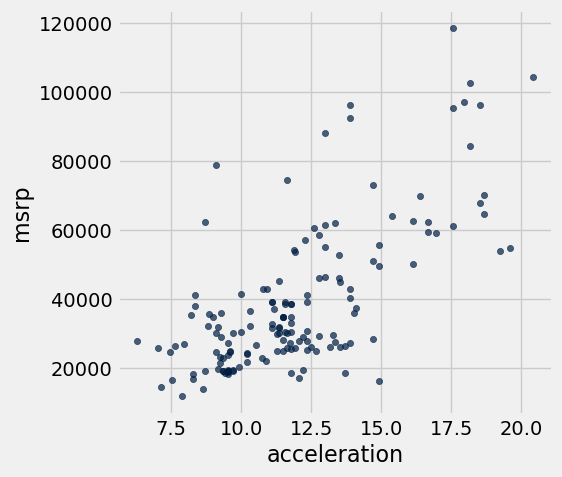

In [6]:
hybrid.scatter('acceleration', 'msrp')

In [7]:
correlation(hybrid, 'acceleration', 'msrp')

0.69557789969139783

### Switching Axes

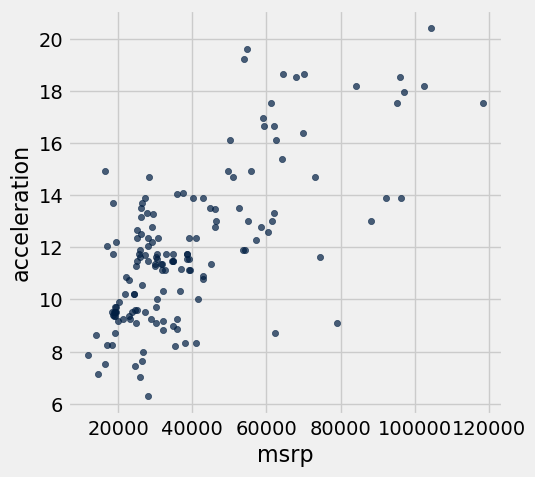

In [8]:
hybrid.scatter('msrp', 'acceleration')

In [9]:
correlation(hybrid, 'msrp', 'acceleration')

0.69557789969139783

### Nonlinearity

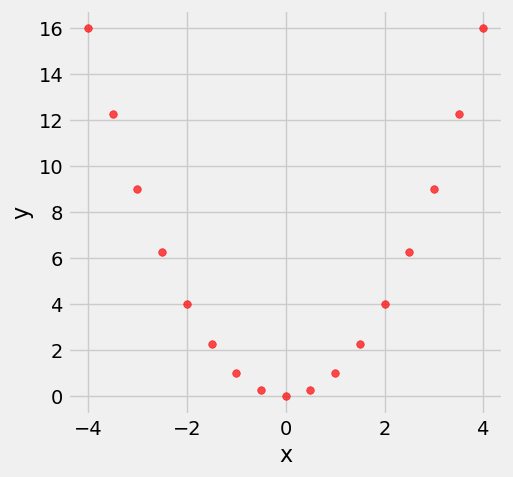

In [10]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')

In [11]:
correlation(nonlinear, 'x', 'y')

0.0

### Outliers

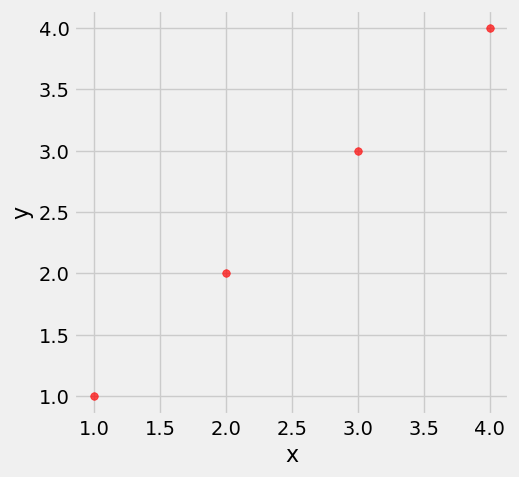

In [12]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y', s=30, color='r')

In [13]:
correlation(line, 'x', 'y')

1.0

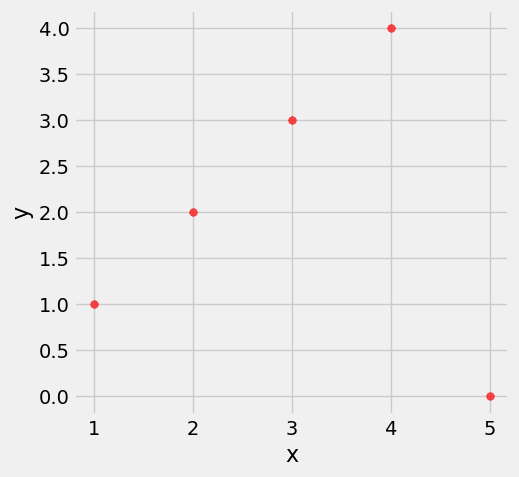

In [14]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y', s=30, color='r')

In [15]:
correlation(outlier, 'x', 'y')

0.0

### Ecological Correlations

In [16]:
sat2014 = Table.read_table('sat2014.csv').sort('State')
sat2014

State                | Participation Rate | Critical Reading | Math | Writing | Combined
Alabama              | 6.7                | 547              | 538  | 532     | 1617
Alaska               | 54.2               | 507              | 503  | 475     | 1485
Arizona              | 36.4               | 522              | 525  | 500     | 1547
Arkansas             | 4.2                | 573              | 571  | 554     | 1698
California           | 60.3               | 498              | 510  | 496     | 1504
Colorado             | 14.3               | 582              | 586  | 567     | 1735
Connecticut          | 88.4               | 507              | 510  | 508     | 1525
Delaware             | 100                | 456              | 459  | 444     | 1359
District of Columbia | 100                | 440              | 438  | 431     | 1309
Florida              | 72.2               | 491              | 485  | 472     | 1448
... (41 rows omitted)

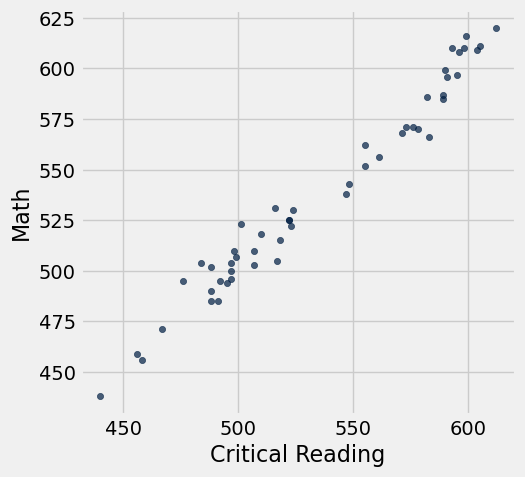

In [17]:
sat2014.scatter('Critical Reading', 'Math')

In [18]:
correlation(sat2014, 'Critical Reading', 'Math')

0.98475584110674341

In [19]:
def rate_code(x):
    if x <= 25:
        return 'low'
    elif x <= 75:
        return 'medium'
    else:
        return 'high'

In [20]:
rate_codes = sat2014.apply(rate_code, 'Participation Rate')

In [21]:
sat2014 = sat2014.with_columns('Rate Code', rate_codes)
sat2014

State                | Participation Rate | Critical Reading | Math | Writing | Combined | Rate Code
Alabama              | 6.7                | 547              | 538  | 532     | 1617     | low
Alaska               | 54.2               | 507              | 503  | 475     | 1485     | medium
Arizona              | 36.4               | 522              | 525  | 500     | 1547     | medium
Arkansas             | 4.2                | 573              | 571  | 554     | 1698     | low
California           | 60.3               | 498              | 510  | 496     | 1504     | medium
Colorado             | 14.3               | 582              | 586  | 567     | 1735     | low
Connecticut          | 88.4               | 507              | 510  | 508     | 1525     | high
Delaware             | 100                | 456              | 459  | 444     | 1359     | high
District of Columbia | 100                | 440              | 438  | 431     | 1309     | high
Florida              | 72.2               | 491              | 485  | 472     | 1448     | medium
... (41 rows omitted)

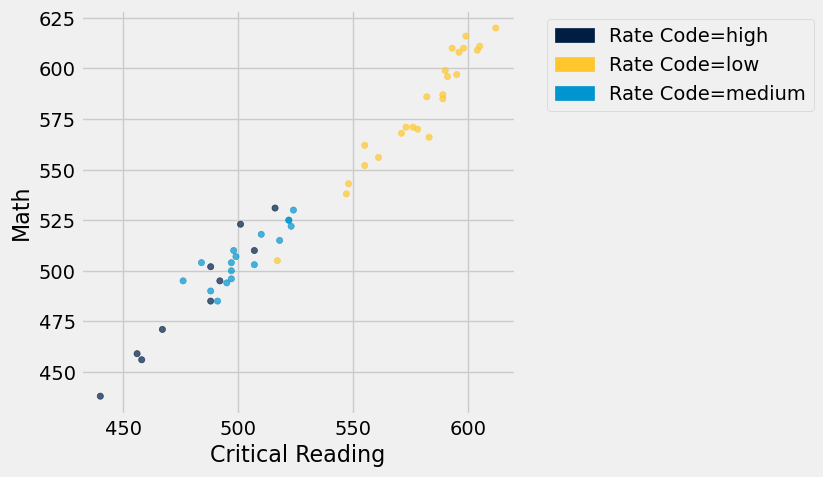

In [22]:
sat2014.scatter('Critical Reading', 'Math', group='Rate Code')

In [23]:
sat2014.where('Rate Code', 'low').show()

## Prediction Lines

### r = 0.99

In [24]:
example = r_table(0.99)
example.show(3)

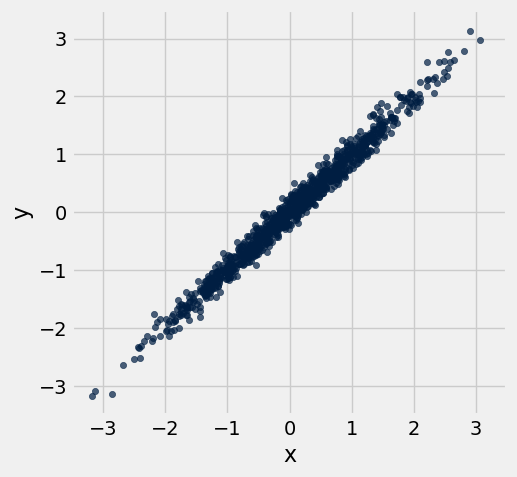

In [25]:
example.scatter('x', 'y')
resize_window()

In [26]:
def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = example.where('x', are.between(x_val - .25, x_val + .25))
    return np.mean(neighbors.column('y'))   

In [27]:
nn_prediction_example(-2.25)

-2.1476337989800522

In [28]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

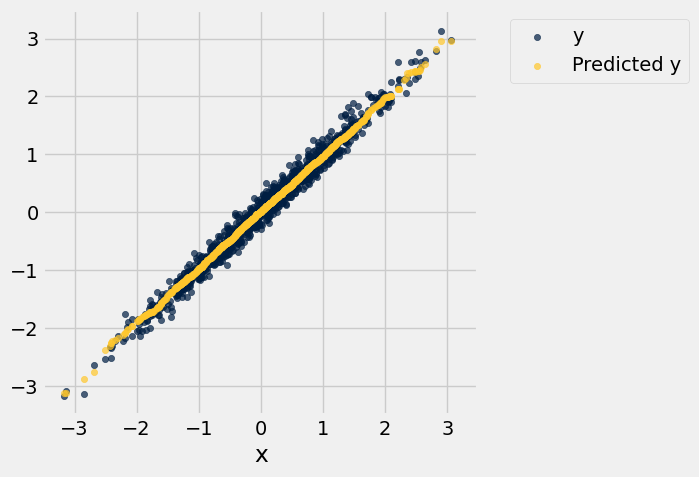

In [29]:
example.scatter('x')
resize_window()

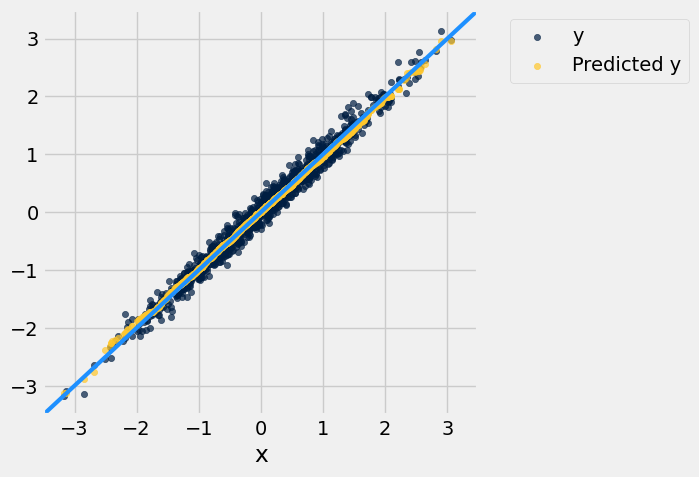

In [30]:
example.scatter('x')
draw_line(slope=1)
resize_window()

### r = 0

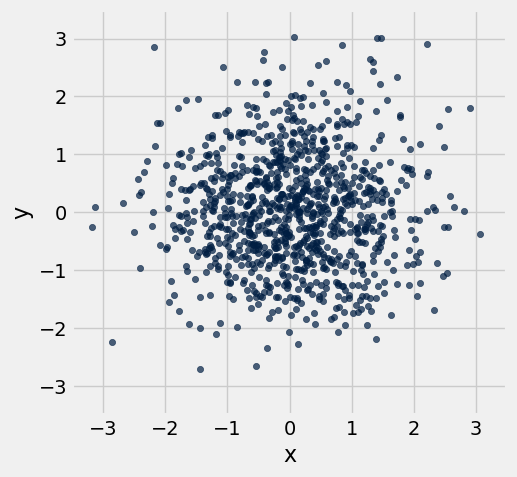

In [31]:
example = r_table(0)
example.scatter('x', 'y')
resize_window()

In [32]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

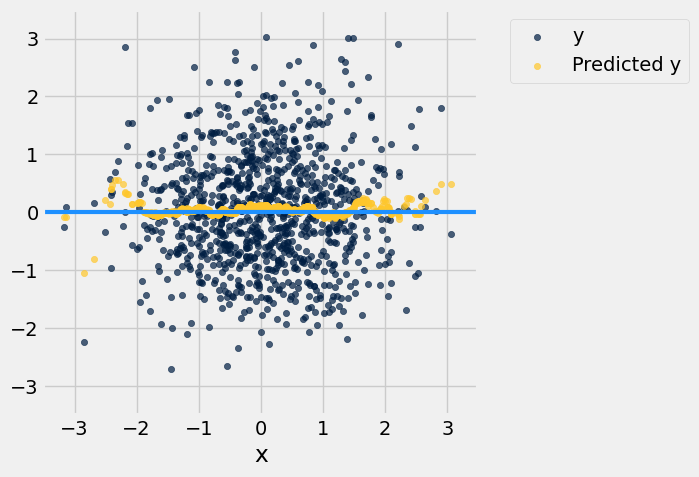

In [33]:
example.scatter('x')
draw_line(slope = 0)
resize_window()

### r = 0.5

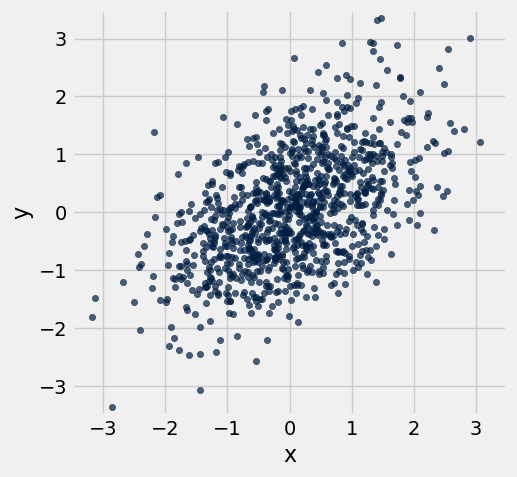

In [34]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()

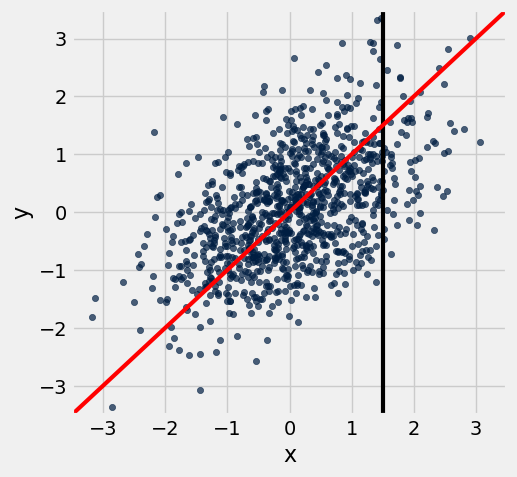

In [35]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()
draw_vertical_line(1.5)
draw_line(slope=1, intercept=0, color='red')

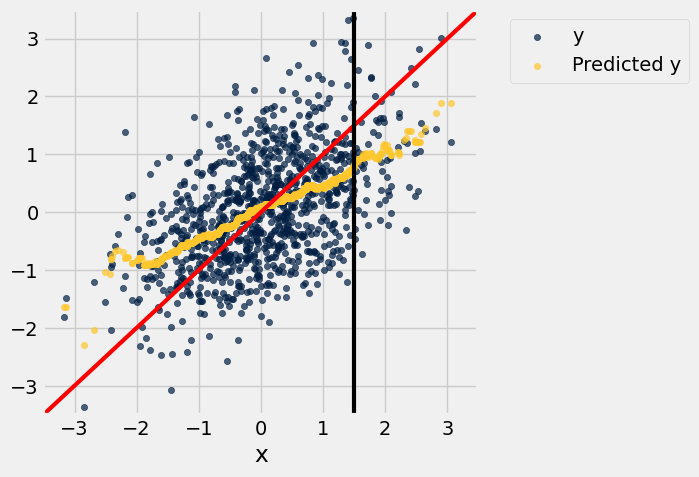

In [36]:
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=1, color='red')
draw_vertical_line(1.5)
resize_window()

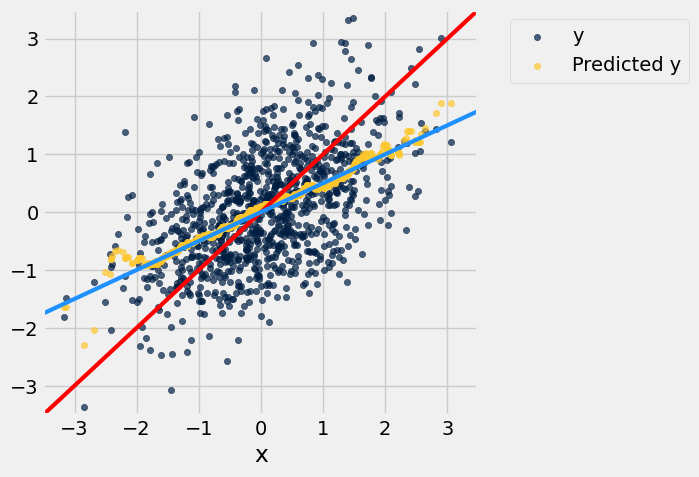

In [37]:
example.scatter('x')
draw_line(slope=1, intercept=0, color='red')
draw_line(slope=0.5, intercept=0)
resize_window()

###  r = 0.7

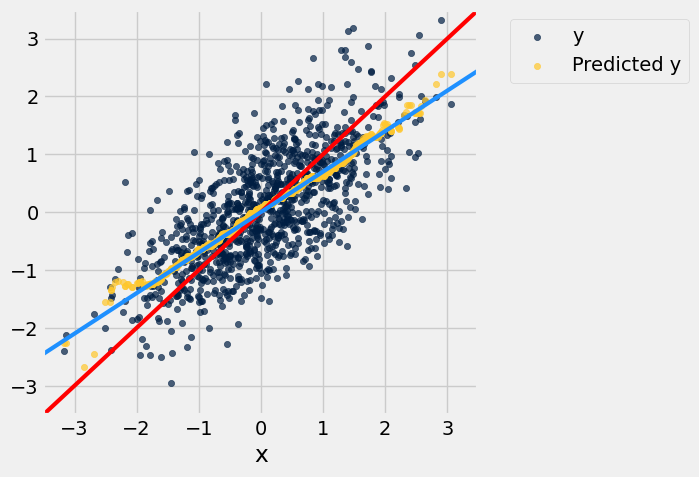

In [38]:
example = r_table(0.7)
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=1, intercept=0, color='red')
draw_line(slope=0.7, intercept=0, color='dodgerblue')
resize_window()

## Linear regression: defining the line

In [39]:
# Copy-pasted from above
def standard_units(x):
    """ Converts an array x to standard units """
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    """ Computes correlation: t is a table, and x and y are column names """
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)


In [40]:
def slope(t, x, y):
    """ Computes the slope of the regression line, like correlation above """
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd


In [41]:
def intercept(t, x, y):
    """ Computes the intercept of the regression line, like slope above """
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

In [42]:
example = r_table(0.5)
slope(example, 'x', 'y')

0.50226382816259152

## Heights Data and Regression Line

In [43]:
# Note: Child heights are the **adult** heights of children in a family
families = Table.read_table('family_heights.csv')
parent_avgs = (families.column('father') + families.column('mother'))/2
heights = Table().with_columns(
    'Parent Average', parent_avgs,
    'Child', families.column('child'),
)
heights.show(5)

In [44]:
def nn_prediction_height(p_avg):
    """Predict the height of a child whose parents have a parent average height of p_avg.
    
    The prediction is the average height of the children whose parent average height is
    in the range p_avg plus or minus 0.5.
    """
    
    close_points = heights.where('Parent Average', are.between(p_avg-0.5, p_avg + 0.5))
    return np.average(close_points.column('Child')) 

In [45]:
heights_with_predictions = heights.with_column(
    'Nearest neighbor prediction', 
    heights.apply(nn_prediction_height, 'Parent Average'))
heights_with_predictions.show(5)

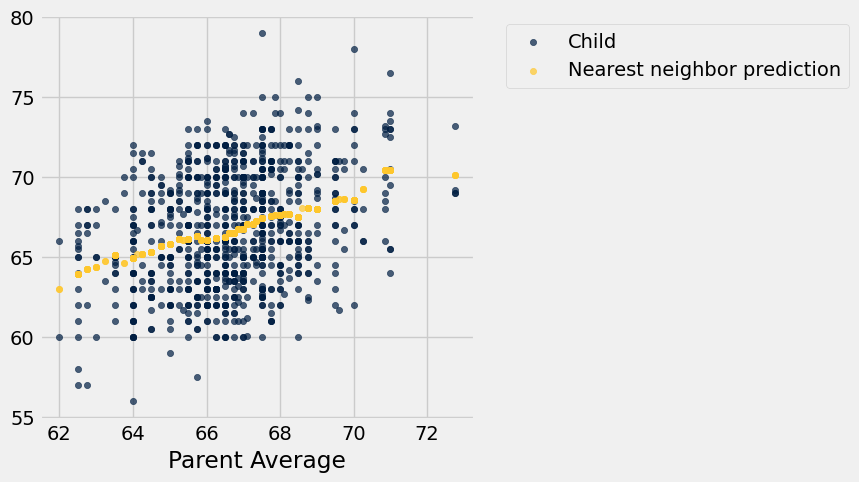

In [46]:
heights_with_predictions.scatter('Parent Average')

In [47]:
predicted_heights_slope = slope(heights, 'Parent Average', 'Child')
predicted_heights_intercept = intercept(heights, 'Parent Average', 'Child')
[predicted_heights_slope, predicted_heights_intercept]

[0.66449526235258838, 22.461839955758798]

In [48]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression Prediction', 
    predicted_heights_slope*heights.column('Parent Average') + predicted_heights_intercept
)
heights_with_predictions

Parent Average | Child | Nearest neighbor prediction | Regression Prediction
72.75          | 73.2  | 70.1                        | 70.8039
72.75          | 69.2  | 70.1                        | 70.8039
72.75          | 69    | 70.1                        | 70.8039
72.75          | 69    | 70.1                        | 70.8039
71             | 73.5  | 70.4158                     | 69.641
71             | 72.5  | 70.4158                     | 69.641
71             | 65.5  | 70.4158                     | 69.641
71             | 65.5  | 70.4158                     | 69.641
69.5           | 71    | 68.5025                     | 68.6443
69.5           | 68    | 68.5025                     | 68.6443
... (924 rows omitted)

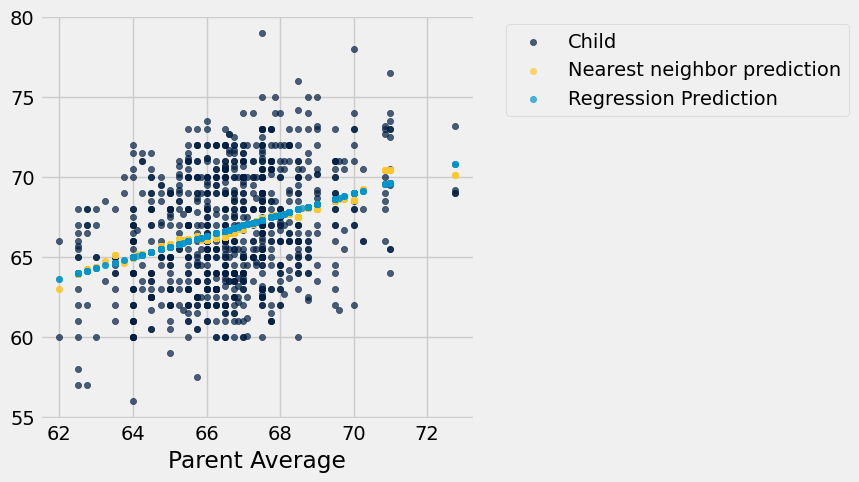

In [49]:
heights_with_predictions.scatter('Parent Average')